# BIOL 175 - Colab 12a (Chapter 18)
# Two-Way ANOVA

This file was made by Dr. Cory Kohn (Scripps and Pitzer Colleges).

###Learning outcomes:
*   Understand and apply two-way ANOVA using R.
*   Practice assumption testing for these models.
*   Interpret model output with a focus on Type III sum of squares.
*   Compare models with different explanatory terms to choose the "best" one.
*   Develop skills in appropriate data visualization techniques for these analyses.

## Type III Sum of Squares
In the context of ANOVA (Analysis of Variance) and ANCOVA (Analysis of Covariance), understanding different types of sums of squares is crucial for accurately interpreting the results of your statistical models, especially when dealing with models that include multiple predictors and their interactions. One key concept here is the Type III sum of squares.

**What is Type III Sum of Squares?**

Type III sum of squares evaluates each main effect and interaction in the model after accounting for the variance explained by all other terms in the model. This is particularly important in models where interactions are present or when the design is unbalanced (i.e., different groups have different sample sizes).

**What is R's default type of sum of squares?**

Unfortunately, R's default is Type I, in which model components are evaluated sequentially. This stands in contrast to the standard approach in many fields, particularly in the analysis of biological data, in which Type III is the norm.

**How do you make R use Type III?**

Unfortunatley, it involves installing the **`car`** package, which takes quite long in Google Colab. We will also need the **`emmeans`** package to interpret the results of these models, **`multcompView`** to make our compact letter display, and **`dplyr`** and **`ggplot2`** to do data manipulation and plotting. Go ahead and install the first three and load all five:

In [ ]:
if (!requireNamespace("car", quietly = TRUE)) {
  install.packages("car")
}
if (!requireNamespace("emmeans", quietly = TRUE)) {
  install.packages("emmeans")
}
if (!requireNamespace("multcompView", quietly = TRUE)) {
  install.packages("multcompView")
}

library(car)
library(emmeans)
library(multcompView)
library(dplyr)
library(ggplot2)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘cowplot’, ‘Deriv’, ‘microbenchmark’, ‘numDeriv’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘Formula’, ‘pbkrtest’, ‘quantreg’, ‘lme4’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘estimability’, ‘mvtnorm’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: carData

Welcome to emmeans.
Caution: You lose important information if you filter this package's results.
See '? untidy'


Attaching package: ‘dplyr’


The following object is masked from ‘package:car’:

    recode


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Two-Way ANOVA

Two-Way ANOVA is used to investigate the effects of two categorical explanatory variables on a continuous response variable. This approach allows for the examination of each of the main effects (i.e., the separate effect of each explanatory variable) as well as the interaction effect between the two categorical variables, which can be crucial in biological research.

Let's begin by loading our data, which involves measuring stickleback fish length across different temperatures and pH levels.

In [ ]:
sticklebacks <- read.csv("8_stickleback_long.csv", stringsAsFactors = TRUE)

Before we fit the model, let's confirm the structure of the dataset. We need to make sure that our explanatory variables are identified by R as factored variables (i.e., categorical) and that the response variable is either a numeric or integer variable (i.e., numerical).

In [ ]:
str(sticklebacks)

'data.frame':	20 obs. of  3 variables:
 $ Temp  : Factor w/ 2 levels "Cold","Warm": 1 1 1 1 1 1 1 1 1 1 ...
 $ pH    : Factor w/ 2 levels "High","Low": 1 1 1 1 1 2 2 2 2 2 ...
 $ Length: num  4.6 4.6 4.3 4.5 4.7 3.4 3 3.2 2.9 3.2 ...


**`Temp`** and **`pH`** are correctly being treated as factors, because they are text and we read in the file with the argument **`stringsAsFactors = TRUE`**. However, if they were coded as zeroes and ones then R would identify them as integers, and we would have had to overwrite the variable using **`factor()`**. **`Length`** is correctly identified as a numerical variable.

It can also be useful to confirm the sample sizes for each factor per categorical variable, as well as each combination of factors; this is the amount of data avaiable for estimating each of the main effects as well as their interaction. We could do this using three different **`table()`** commands, one per main effect or their combination. Instead we can wrap **`addmargins()`** around a single table command.

In [ ]:
addmargins(table(sticklebacks$Temp, sticklebacks$pH))

,High,Low,Sum
Cold,5,5,10
Warm,5,5,10
Sum,10,10,20


This shows us that we have a completely balanced design with n = 5 per each combination of pH and temperature, so n = 10 per each factor per variable, and a total sample size of N = 20.

This is decidedly underpowered -- we don't have a lot of data in order to make great estimates of statistical signficance. We can still perform two-way ANOVA and reach valid conclusions, but this isn't an ideal situation. What is ideal? That depends on the hypothesized effect size, number of levels (i.e., groups) per variable, α (probability of type I error, making a false positive), and β (probability of type II error, making a false negative; therefore power = 1 - β). For a "medium" effect size, with a small 2x2 design like we have here, and the usual α = 0.5 and power = 0.8, we ideally want a sample size of at least 10-15 replicates per group (N = 40-60).

### The model
Let's proceed with fitting the linear model using the **`lm()`** function as before for ANOVA and linear regression, but considering each of the main effects of Temperature and pH and also their interaction effect (which R will denote as **`Temp:pH`**).

In [ ]:
sticklebacksANOVAinteraction <- lm(Length ~ Temp * pH, data = sticklebacks)

With this model we are testing three null hypotheses:
1. Stickleback length is not affected by water temperature (i.e., mean length is equivalent across temperature groups).
2. Stickleback length is not affected by water pH (i.e., mean length is equivalent across pH groups).
3. The effect of water temperature on stickleback length is not influenced by water pH, and vice versa (i.e., mean length is equivalent across all combinations of temperature and pH groups).

If we would have wanted the main effects only, without the interaction effect, we would have modeled this as **`Temp + pH`** instead (note the **`+`** instead of **`*`**) -- this would have tested only the first two null hypotheses above. Note that the **`Temp * pH`** notation is actually shorthand for: **`Temp + pH + Temp:pH`**.

### Understanding the residuals

Remember that as we saw with ANOVA and linear regression, we will check the assumptions of two-way ANOVA by inspecting the residuals of the model. Residuals are the differences between the observed values for the response variable and the values predicted by the model. For two-way ANOVA, that means the difference between the observed response value and its group mean when considering it's membership in both groups. Just to demonstrate this definition for the residuals, here is dplyr code that calculates this difference, and side-by-side histrograms demonstrating that this dataset is identical to the residuals of the two-way ANOVA model.

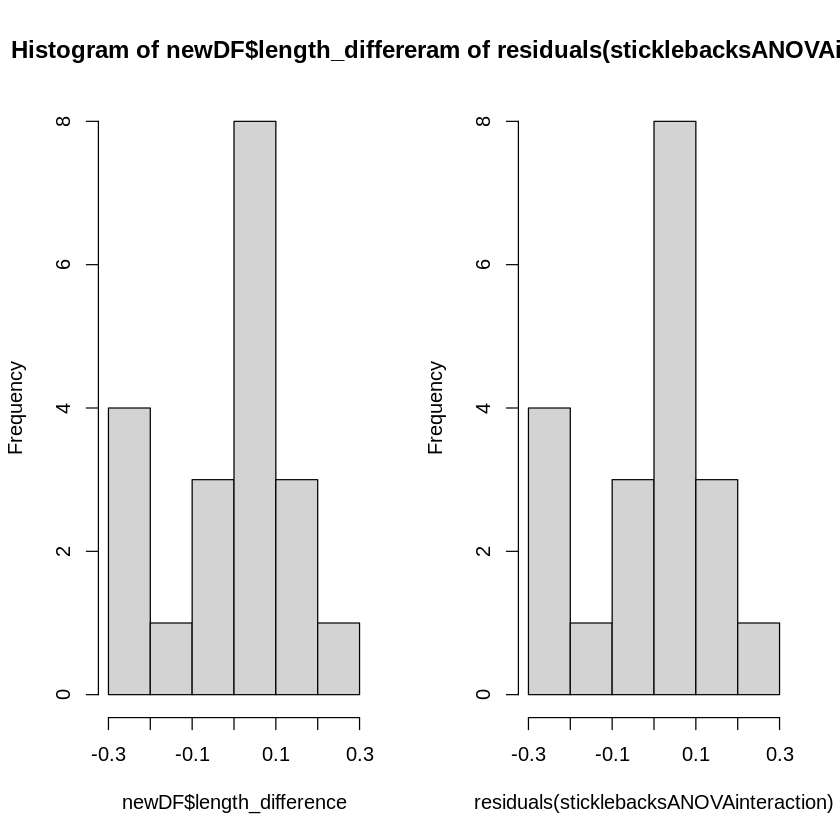

In [ ]:
library(dplyr)

newDF <- sticklebacks %>% group_by(Temp, pH) %>%
  mutate(length_difference = Length - mean(Length))

par(mfrow = c(1, 2)) # this changes the plotting field so the next two plots are on one row with two columns
hist(newDF$length_difference)
hist(residuals(sticklebacksANOVAinteraction))
par(mfrow = c(1, 1)) # this resets the plotting field to be a single plot

Just like for one-way ANOVA and linear regressions you saw before, you never need to perform the above code yourself. This is simply demonstrating the definition of residuals for the context of our model.

### Assumption testing
We'll largely stick to visual assessments for assumption testing, and evaluating the same assumptions as for one-way ANOVA: **normality** of the residuals using a histrogram and QQ plot, **homoscedasticity** of the residuals (equal variances across groups) using a scatterplot with the predicted (i.e., "fitted") values and boxplots for each group, and **independence** using a scatterplot of the residuals in the order they are listed in the dataset.

There are two key differences for the two-way ANOVA context, and they relate to homoscedasticity. Remember that we have two types of plots for evaluating this: using a scatterplot with the predicted (i.e., "fitted") values and boxplots for each group. For the boxplots, does "each group" mean for the first categorical variable, the second categorical varaible, or their combination via the interaction component of the model? *Yes!* Include each of those boxplot variants in your assumption testing -- If  your model includes the main effects and the interaction then inspect all three types of boxplots. If it lacks the interaction then inspect just the main categorical variables only.

Here are all of the visual assumption testing plots for our example:

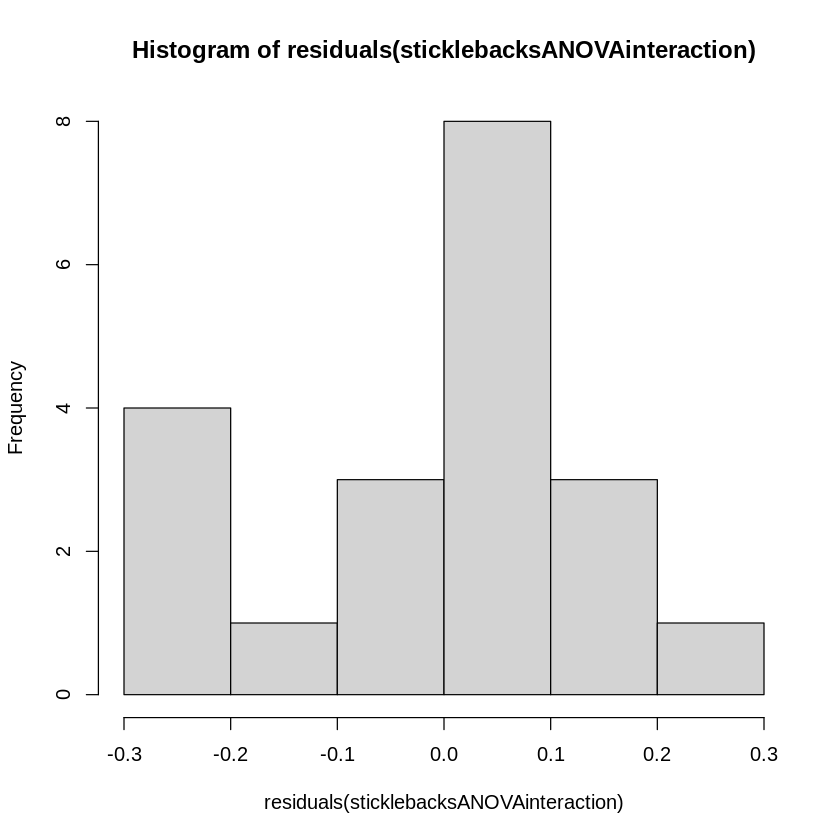

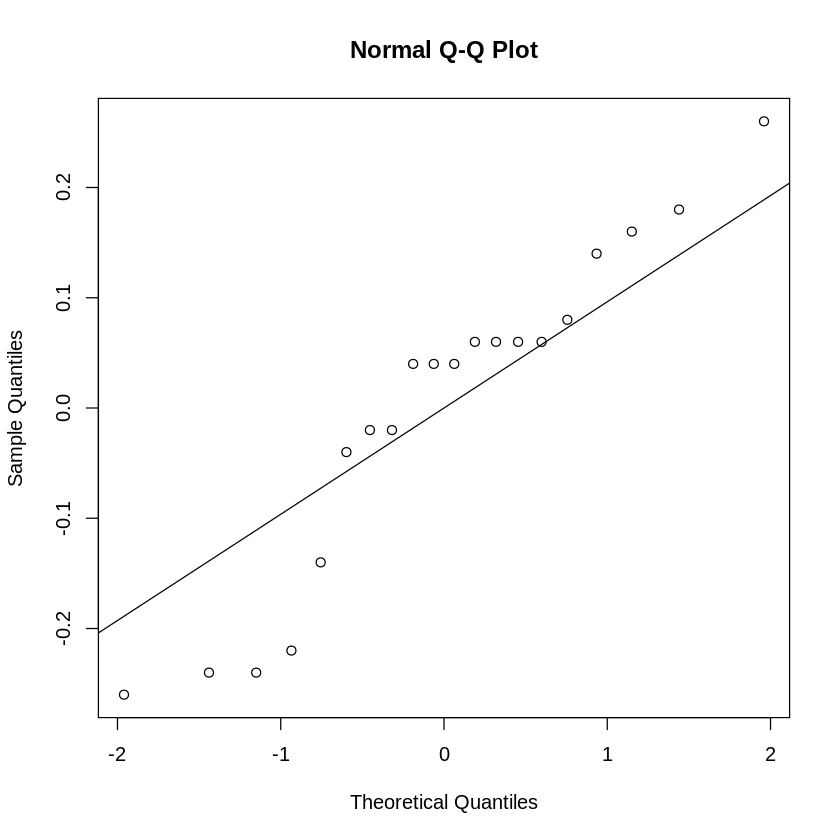

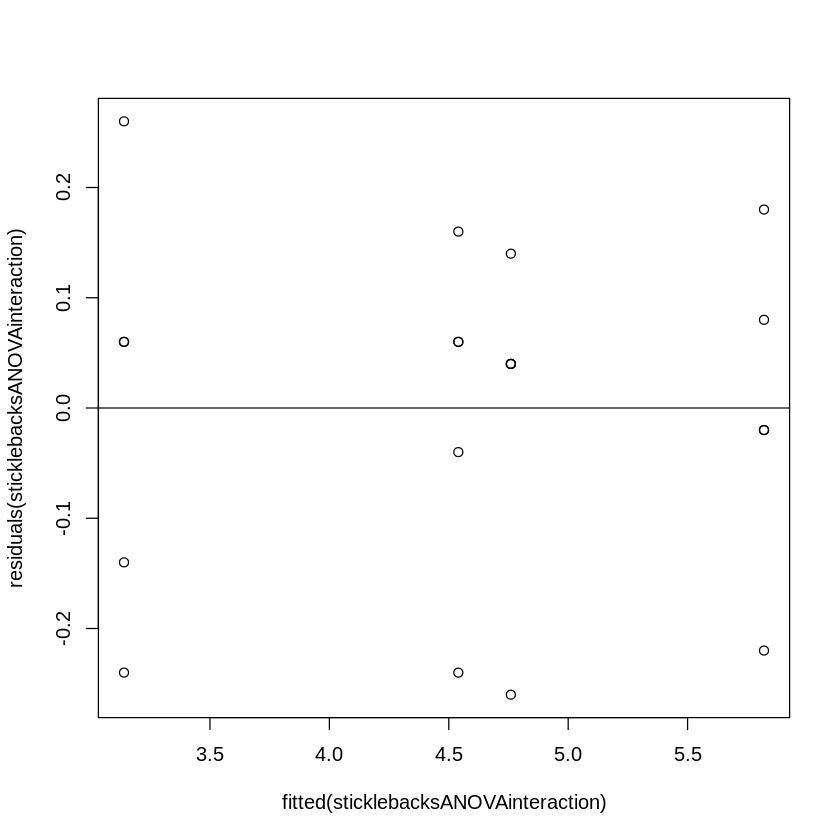

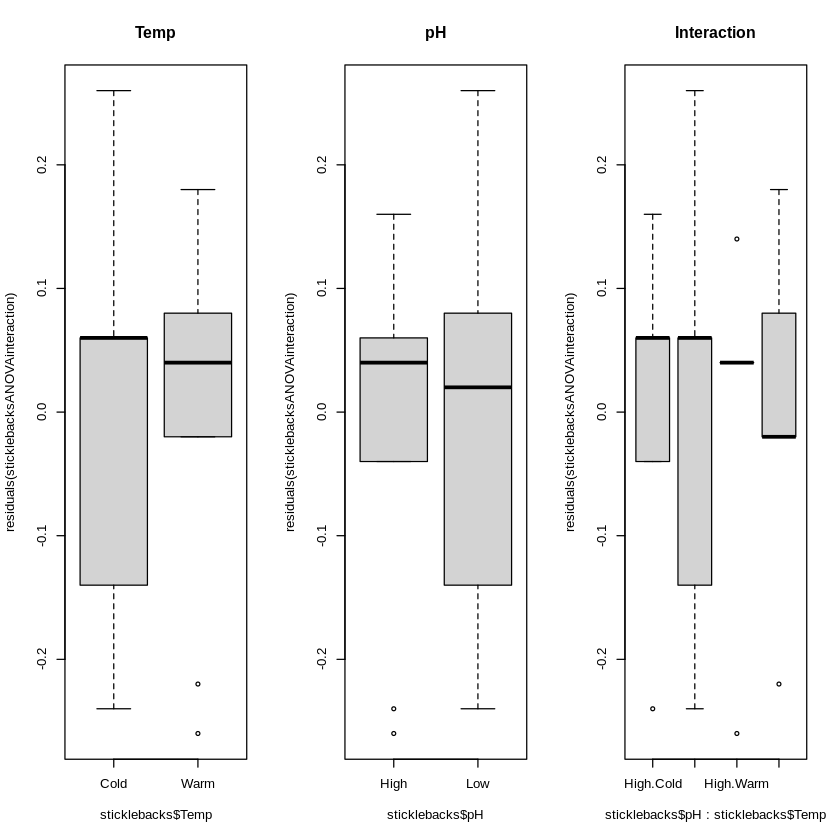

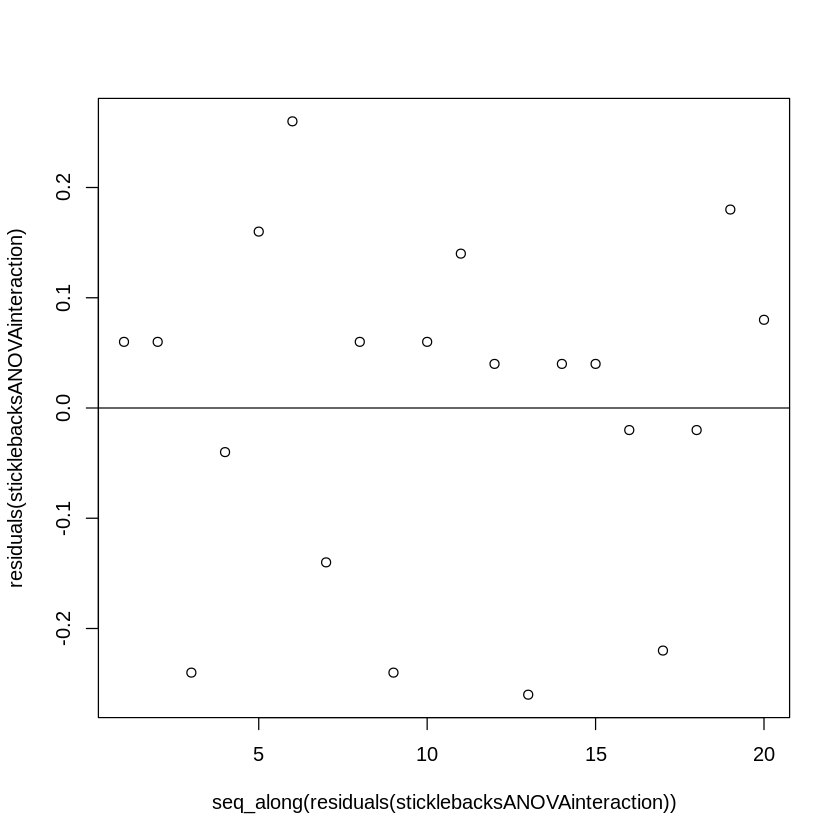

In [ ]:
# Normality
hist(residuals(sticklebacksANOVAinteraction))
qqnorm(residuals(sticklebacksANOVAinteraction))
qqline(residuals(sticklebacksANOVAinteraction))

# Homoscedasticity
plot(residuals(sticklebacksANOVAinteraction) ~ fitted(sticklebacksANOVAinteraction), data = sticklebacks)
abline(h=0)
par(mfrow = c(1, 3)) # To plot the next three plots side by side
boxplot(residuals(sticklebacksANOVAinteraction) ~ sticklebacks$Temp, main = "Temp")
boxplot(residuals(sticklebacksANOVAinteraction) ~ sticklebacks$pH, main = "pH")
boxplot(residuals(sticklebacksANOVAinteraction) ~ sticklebacks$pH : sticklebacks$Temp, main = "Interaction") # Include this only if your model has the interaction term
par(mfrow = c(1, 1)) # resets the plotting field to be a single plot

# Independence
plot(residuals(sticklebacksANOVAinteraction) ~ seq_along(residuals(sticklebacksANOVAinteraction)))
abline(h = 0)

Normality is fine; not great, but probably OK since ANOVA is fairly robust to this violation.

Homoscedasity via the scatterplot seems fine. Note that we have four groups of points arranged in vertical columns, which makes sense because we have a fully-factorial experimental design with two Temp groups and two pH groups, so four total groups (with a mean calculated for each combination of groups, which is the four x-axis positions). Also note that we don't have too many data values per each of these four groups (which we saw in the 2x2 sample size table with marginal sums when we read in the data), so...

Homoscedasity via the boxplots seems potentially concerning, especially in the third subplot, which shows the variance of the residuals for the interaction (i.e., each of the four combinations of groups). There aren't many values in each of those four groups, so it would be hard to get nice boxplot results simply based on these small sample sizes.

Independence via the residual plot looks fine. If it wasn't, remember that this could indicate a problem with independence, or it could mean that our data were simply sorted in the dataset. This is the best we can do for assessing independence using the data only, but we would do even better by thinking more about how the experiment was actually designed and conducted. In this case, the data are actually sorted by treatment, so even though it looks fine, we can't use this plot to judge anyway.

Homoscedasity, especially with the boxplot for the interaction, seems potentially suspect. Let's do an additional analysis -- Levene's Test. This is a hypothesis test for the null hypothesis that variance is equivalent across groups (p < α indicates a lack of homoscedasity). I *do not* recommend that you rely on it alone (for similar reasons why I don't recommend the Shapiro-Wilk test for evaluating the normality assumption), but as an extra measure for checking the equal variance assumption for the interaction term specifically, I think it is a nice aid to inspecting the residual scatterplot and boxplot.

FYI, Levene's Test using **`leveneTest`** requires the **`car`** package, which we will need to evaluate the Type III Sum of Squares model output anyway.

We could use Levene's Test for the same boxplot variations above (per each categorical variable or per their group interaction): **`~ pH`**, **`~ Temp`**, or **`~ Temp:pH`**. I recommend that you routinely only perform it for the interaction term, which is probably the one you're most likely to question homoscedasity for. If you have sufficient desire to perform it for the main effects, then I can't stop you, but it's probably unnecessary or even [harmful](https://pubmed.ncbi.nlm.nih.gov/15171807/).

In [ ]:
leveneTest(residuals(sticklebacksANOVAinteraction) ~ Temp : pH, data = sticklebacks) # Include this only if your model has the interaction term

,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,3,0.2111111,0.8872226
,16,NA,NA


A significant test (p < 0.05) suggests that the variances of the residuals are not equal for the interaction term. There's no evidence of that here (p > 0.05). So even though our third boxplot:
```
boxplot(residuals(sticklebacksANOVAinteraction) ~ sticklebacks$pH : sticklebacks$Temp, main = "Interaction")
```
was wonky, it's probably just due to the small sample size per each combination of groups.

### Outliers and influential data

As before with one-way ANOVA and linear regression, we care about identifying potential outliers and overly inflential datapoints. See earlier Colabs for understanding why these are problems and how to think about interpreting your options when you find suspected issues. We'll use the same code as before:

In [ ]:
# Identify potential outliers with absolute standardized residuals greater than 2
outliers <- which(abs(rstandard(sticklebacksANOVAinteraction)) > 2)
print(outliers)  # If none found, this prints: named integer(0)

# Identify potential overly influential values using Cook's distance
influentials <- which(cooks.distance(sticklebacksANOVAinteraction) > 1)
print(influentials)  # If none found, this prints: named integer(0)

# Print the rows of data corresponding to potential outliers and influentials
sticklebacks[outliers, ]  # If none found, this prints zero data rows
sticklebacks[influentials, ]  # If none found, this prints zero data rows

named integer(0)
named integer(0)


Temp,pH,Length
<fct>,<fct>,<dbl>


Temp,pH,Length
<fct>,<fct>,<dbl>


Having no results here is fantastic!

### Model outputs: ANOVA table
Once we're satisfied that the model is meeting its assumptions adequately well (which might have included performing a transformation of the response variable, which wasn't necessary in this example), we can proceed to checking the output of the models.

As we saw in lab 10 with one-way ANOVA, we can use **`anova()`**, **`summary()`**, and **`TukeyHSD(aov())`**. These work just fine for Type I SS models (including simple models like one-way ANOVA and linear regression where it doesn't matter). But remember that Type III SS models are preferable for more complex biological analyses where there are multiple predictors.

For Type III models, use the function **`Anova()`**, with the capital A, from the **`car`** package to get the ANOVA table, use a custom function **`calculate_r_squared`** to calculate R-squared and adjusted R-squared using the results from **`Anova()`**, and use **`pairs`** with **`emmeans`** from the **`emmeans`** package to calculate Tukey HSD results.

In [ ]:
# Type III sum of squares ANOVA table with df, F-values, p-values
Anova_sticklebacksANOVAinteraction <- Anova(sticklebacksANOVAinteraction, type = "III") # Note: 'A' in Anova is capitalized
Anova_sticklebacksANOVAinteraction

,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),103.0580,1,3888.981132,1.562785e-20
Temp,0.1210,1,4.566038,4.840269e-02
pH,4.9000,1,184.905660,3.296674e-10
Temp:pH,7.5645,1,285.452830,1.267076e-11
Residuals,0.4240,16,NA,NA


You can usually ignore the "intercept" line. The intercept term represents the grand mean of the response variable adjusted for the effects of the other terms in the model; it does not provide information about the effects of the predictors. It's magnitude (and p-value significance compared to 0) is a matter of the scale of measurement for the response variable. You can think if it like a one-sample t-test on whether the grand mean = 0; it's not exactly like this, because the intercept's adjustment redistributes variability based on the factor levels, so the intercept reflects the grand mean after accounting for the influence of other terms in the model. In contrast, a one-sample t-test evaluates the mean of the entire dataset without considering grouping factors or interactions, treating all observations as part of a single homogeneous population. This distinction highlights a key difference between Type I (SS I) and Type III (SS III) models: SS I models test sequentially, attributing variability to terms in the order they appear in the model, while SS III models test terms as if they were orthogonal, adjusting for all other terms regardless of their position in the model.

Before your eyes jump to the p-value column, inspect the df column to confirm that it matches your expectation based on the design of your model (k = number of groups, per variable) and your overall sample size (N = sum of n across groups). For the intercept, df is always 1. For each of the main effects, df = k - 1; for our example, each of the main effects variables has two groups, so df = 1 for each variable. For the interaction term, df = the product of df for each main effect. For the residuals, df = N - k*k, where each k is specific to one of the explanatory variables. For total df (not shown), which is the sum of the non-intercept df values, df = N - 1. If one of the df values does not make sense then you have either accidentally fit an incorrect model (e.g., ANCOVA instead because R is treating one of your categorical variables as numerical instead), or your model design is not what you thought it was.

Focus on the p-value for each model component, which was evaluated using the F-statistic for that component with degrees of freedom equal to that component and the residuals.

Here, each of the model components are significant, although Temp is just barely below α at 0.05. So water temperature affects fish length, water pH affects fish length, and a combination of these factors produces unique results too.

### Model outputs: R² and Adjusted R²

We use R-squared to understand the model's explanatory power. R-squared is calculated as the proportion of variance explained by the model. However, note that summary() uses Type I SS, which partitions variance sequentially, while biologists often prefer Type III SS to account for all other terms in the model when evaluating a predictor.

Let's see this in action:

In [ ]:
summary(sticklebacksANOVAinteraction)$r.squared

[1] 0.9772599

Remember that R-squared ranges from 0 to 1, so our model is performing very well. But wait a sec!

We saw in earlier Colabs and lectures on one-way ANOVA and linear regression that R-squared is the proportion of variance in the response variable that is explained by the model: R-squared = SSgroup/SStotal for the one-way ANOVA case or equivalently, R-squared = SSregression/SStotal for linear regression. Generally, for linear models: **R-squared = SSmodel/SStotal**.

SSmodel is the summation of SS (sum of squares) for each component in the model (excluding the intercept). And SStotal is SSmodel + SSresiduals. For our two-way ANOVA example, SSmodel = SStemp + SSph + SStemp:ph = 0.1210 + 4.9 + 7.5645 = 12.5855. SStotal = 12.5855 + 0.4240 = 13.0095. And therefore R-squared = 0.9674... so, why does **`summary()`** calculate 0.9773 instead? Because **`summary()`** uses Type I SS to calculate each SS value instead of the Type III SS, which is what I and most biologists recommend.

Please use this custom function for analyses more complex than one-way ANOVA and simple linear regression (i.e., in cases for which Type III SS matters), since R doesn't natively calcualte R-squared and adjusted R-squared using Type III SS:

In [ ]:
calculate_r_squared <- function(Anova_results) {
  # Extract sums of squares, excluding the intercept
  ss_model <- sum(Anova_results$`Sum Sq`[-c(1, nrow(Anova_results))])  # Exclude intercept and residuals (first and last row)
  ss_residuals <- Anova_results$`Sum Sq`[nrow(Anova_results)]          # Residual sum of squares (last row)
  ss_total <- ss_model + ss_residuals                                  # Total sum of squares

  # Calculate R-squared
  r_squared <- ss_model / ss_total

  # Calculate the number of observations using degrees of freedom
  n_observations <- sum(Anova_results$Df)  # Total observations = sum of Df (intercept + model + residuals)

  # Calculate the number of predictors (excluding intercept and residuals)
  p <- nrow(Anova_results) - 2

  # Calculate adjusted R-squared
  adj_r_squared <- 1 - ((1 - r_squared) * (n_observations - 1) / (n_observations - p - 1))

  # Return results as a named list
  return(list(
    r.squared = r_squared,
    adj.r.squared = adj_r_squared
  ))
}

calculate_r_squared(Anova_sticklebacksANOVAinteraction)

$r.squared
[1] 0.9674084

$adj.r.squared
[1] 0.9612975

Copy the **`calculate_r_squared`** function code, all lines that include the curly braces **`{`...`}`**, into whatever Colab file you're using and call that code block to read-in the custom function into R. Then you can use it by storing the result of **`Anova`** as a variable and calling the function using that variable, as shown in the example above.

The first part of that function uses the definition of R-squared, as explained above, and simply pulls the Type III SS values from the table of results. The second part impliments the definition of adjusted R-squared.

Adjusted R-squared is even more important than R-squared. Interpret it's value the same way as for R-squared: the proportion of variance in the response variable that is explained by the model. It is "adjusted" with respect to the size of the model specifically using the ratio of dftotal to dfresiduals (n-1)/(n-p-1), where p = number of predictors. This adjustment is helpful so that we avoid overfitting: R-squared can be misleading because it will invariably increase with the complexity (number of predictors) of the model, even if many of those predictors don't truly improve the model's explanatory power. Adjusted R-squared corrects for this. A high adjusted R-squared means the model explains varaince efficiently without overfitting. Comparing the explanatory performance of models of different complexities (e.g., a model *with* versus *without* the interaction) is best made using adjusted R-squared.

Note that if the model explains very little of the variation then R-squared will be near zero. If the model is also relatively complex, adjusted R-squared might even be negative!

### Model outputs: Group Means and Tukey HSD results

Our two-way ANOVA result showed that all three model components were significant: each of the main effects (Temperature and pH) and also their interaction. So what are the estimated response variable means for each group? And which groups have significantly different means compared to which other groups?

You might expect that our best estimate of the mean for each combination of groups would be exactly that observed for each group separately:

In [ ]:
sticklebacks %>% group_by(Temp, pH) %>%
    summarise(
    mean = mean(Length), # Edit response variable accordingly
    n = n(),
    se = sd(Length) / sqrt(n), # Edit response variable accordingly
    lower_ci = mean - qt(0.975, df = n-1) * se, # the same as t.test(age)$conf.int[1]
    upper_ci = mean + qt(0.975, df = n-1) * se  # the same as t.test(age)$conf.int[2]
  )

`summarise()` has grouped output by 'Temp'. You can override using the
`.groups` argument.


Temp,pH,mean,n,se,lower_ci,upper_ci
<fct>,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
Cold,High,4.54,5,0.06782330,4.351692,4.728308
Cold,Low,3.14,5,0.08717798,2.897955,3.382045
Warm,High,4.76,5,0.06782330,4.571692,4.948308
Warm,Low,5.82,5,0.06633250,5.635831,6.004169


However this isn't exactly the case. Instead, the best estimate for group means comes from our model in which we are explicitly predicting the response variable given the explanatory variables. The model, especially if it was created using unbalanced data (differing sample sizes per group), will produce estimated means that might differ from those observed for each group -- and this is exactly what you want! -- use the model to make your predictions.

We can do this using the **`emmeans`** function from the **`emmeans`** package. We call the function using our model and respecifying the explanatory variable components of the model. First we'll look at the interaction term:

In [ ]:
emmeans_sticklebacksANOVAinteraction <- emmeans(sticklebacksANOVAinteraction, ~ Temp : pH)
emmeans_sticklebacksANOVAinteraction

 Temp pH   emmean     SE df lower.CL upper.CL
 Cold High   4.54 0.0728 16     4.39     4.69
 Warm High   4.76 0.0728 16     4.61     4.91
 Cold Low    3.14 0.0728 16     2.99     3.29
 Warm Low    5.82 0.0728 16     5.67     5.97

Confidence level used: 0.95 

This gives us the mean but also a more precise measurement of SE, which is based on all of the data since the linear model assumes homoscedasticity, and thefore more precise upper and lower confidence limits (intervals).

We can see that the treatment combination that yielded the smallest fish was cold, low pH water. And the largest fish were observed in warm, low pH water -- this powerfully shows the effect size of the significant interaction term! Each of the terms in the two-way ANOVA were significant, so presumably at least these two most-extreme treatment means are statistically significant from one another. But is each of the four different combinations of water temp and pH different from one another? Let's perfrom Tukey HSD tests.

We can use the results of the **`emmeans()`** function in a call to **`pairs`** with the option **`adjust="tukey"`** to calculate our Tukey HSD results:

In [ ]:
pairs(emmeans_sticklebacksANOVAinteraction, adjust = "tukey")

 contrast              estimate    SE df t.ratio p.value
 Cold High - Warm High    -0.22 0.103 16  -2.137  0.1837
 Cold High - Cold Low      1.40 0.103 16  13.598  <.0001
 Cold High - Warm Low     -1.28 0.103 16 -12.432  <.0001
 Warm High - Cold Low      1.62 0.103 16  15.735  <.0001
 Warm High - Warm Low     -1.06 0.103 16 -10.296  <.0001
 Cold Low - Warm Low      -2.68 0.103 16 -26.030  <.0001

P value adjustment: tukey method for comparing a family of 4 estimates 

We now know that all pairwise treatment combinations are significant except cold vs. warm water with high pH.

We knew from the p-values in the overall ANOVA table (generated with **`Anova()`** earlier) that separately each of the main effects are significant. But does warmer or colder water yield longer fish (when holding pH constant)? And does higher or lower pH yield longer fish (when holding temp constant)?

We can use two more calls for **`emmeans()`**, one per variable:

In [ ]:
emmeans(sticklebacksANOVAinteraction, ~ Temp)
emmeans(sticklebacksANOVAinteraction, ~ pH)

NOTE: Results may be misleading due to involvement in interactions



 Temp emmean     SE df lower.CL upper.CL
 Cold   3.84 0.0515 16     3.73     3.95
 Warm   5.29 0.0515 16     5.18     5.40

Results are averaged over the levels of: pH 
Confidence level used: 0.95 

NOTE: Results may be misleading due to involvement in interactions



 pH   emmean     SE df lower.CL upper.CL
 High   4.65 0.0515 16     4.54     4.76
 Low    4.48 0.0515 16     4.37     4.59

Results are averaged over the levels of: Temp 
Confidence level used: 0.95 

From these results we now see that the directionality of the modeled cause-effect relationship is that warmer water produces longer fish and high pH produces longer fish.

### Results paragraph
That's a lot of results! How can we synthesize the most important bits into a cohesive story? Here's an overall summary of the two-way ANOVA results:

Water pH had the largest effect on stickleback rearing, with higher pH yielding significantly longer fish (two-way ANOVA, F(1, 16) = 184.9, p < 0.0001). Water temperature also had a significant effect (two-way ANOVA, F(1, 16) = 4.57, p = 0.0484), with warmer water yielding longer fish than cooler water. The interaction between temperature and pH was also significant (two-way ANOVA, F(1, 16) = 285.5, p < 0.0001). Examining the Tukey HSD test's pairwise comparisons for the interaction effect, all were significant (p < 0.0001) except for warm high pH water (4.76 cm) compared to cold high pH water (4.54 cm; p = 0.184). The largest effect was observed when comparing warm low pH (5.82 cm) to cold low pH water (3.14 cm). The overall model explained a great deal of the variation in the response variable with an adjusted R-squared value of 0.961.

Can you see how all of the results from those various functions came together to produce a nice overall statement about how temperature, pH, and their interaction affected fish length? Try to match each number in the paragraph to it's inclusion among the R code results.

Would you include greater or fewer results in your results paragraph? Would you emphasize some of the outputed values more than I did or contextualize them differently? There's no "right" answer here other than that you want to accurately and clearly explain your results and with as much detail as you think your reader wants (and needs) to know. You can (and should if possible) publish your raw data and R code so that your reader can inspect all of the output if they so choose.

### The plot

Recall that strip charts and violin plots are nice representations of groups of numerical data, and that we can add means and 95% confidence intervals to these plots to make them even more informative. And we can add compact letter display (CLD) to our plots to show our Tukey results; groups that cannot be distinguished share the same letter whereas groups that are different get different letters. We did all of this in Colab 10 for one-way ANOVA situations; we'll do so again now for two-way ANOVA situations.

First we need to construct the CLD labels for each combination of treatments. Since we're using the Type III SS framework, we need to use **`emmeans`** to calculate our means, 95% CIs, and Tukey results. Unfortunately, **`emmeans`** doesn't nicely interact with our **`multcompLetters`** function, so we need to do quite a bit of work to rearrange our Tukey results into a format that we can use to create the CLD labels. I have all of that work formatted as a function that you can call on your output from **`emmeans`**:

In [ ]:
generate_cld <- function(emm) {
  # Convert emm to a data frame if it's not already
  emm_df <- as.data.frame(emm)

  # Sort emm_df by emmean in descending order
  emm_df <- emm_df[order(-emm_df$emmean), ]

  # Create contrasts and extract p-values
  tukey <- data.frame(pairs(emm, adjust = "tukey"))
  contrasts <- tukey$contrast
  pvalues <- tukey$p.value

  # Extract unique treatment combinations in the sorted order of means
  sorted_treatments <- emm_df$Treatment <- apply(emm_df[, 1:2], 1, paste, collapse = " ")

  # Initialize a square matrix
  pvalue_matrix <- matrix(NA, nrow = length(sorted_treatments), ncol = length(sorted_treatments))
  rownames(pvalue_matrix) <- sorted_treatments
  colnames(pvalue_matrix) <- sorted_treatments

  # Populate the matrix with p-values
  for (i in seq_along(contrasts)) {
    contrast <- strsplit(as.character(contrasts[i]), " - ")[[1]]
    row <- contrast[1]
    col <- contrast[2]
    pvalue <- pvalues[i]

    pvalue_matrix[row, col] <- pvalue
    pvalue_matrix[col, row] <- pvalue
  }

  # Set the diagonal to zero (no self-comparisons)
  diag(pvalue_matrix) <- 0

  # Generate CLD letters using multcompLetters
  cld <- multcompLetters(pvalue_matrix)
  letters_df <- data.frame(Treatment = names(cld$Letters), Letters = cld$Letters, row.names = NULL)

  # Left join the CLD letters to the emm data frame
  emm_with_letters <- merge(emm_df, letters_df, by = "Treatment", all.x = TRUE)

  return(emm_with_letters)
}

Execute that code cell to read-in the function into R. Then call the **`generate_cld`** function using the output from **`emmeans`**. For example, recall that earlier we created:
```
emmeans_sticklebacksANOVAinteraction <- emmeans(sticklebacksANOVAinteraction, ~ Temp * pH)
```
So now we can call the custom CLD function using that output:

In [ ]:
cld_sticklebacksANOVAinteraction <- generate_cld(emmeans_sticklebacksANOVAinteraction)
cld_sticklebacksANOVAinteraction

Treatment,Temp,pH,emmean,SE,df,lower.CL,upper.CL,Letters
<chr>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Cold High,Cold,High,4.54,0.0728011,16,4.385669,4.694331,b
Cold Low,Cold,Low,3.14,0.0728011,16,2.985669,3.294331,c
Warm High,Warm,High,4.76,0.0728011,16,4.605669,4.914331,b
Warm Low,Warm,Low,5.82,0.0728011,16,5.665669,5.974331,a


This created our summary dataframe that contains the treatment means, 95% CI upper and lower limits, and CLD labels.

Note that in this case the 95% CIs are created using the two-way ANOVA model, which estimates the SE for each group using all of the variance within every group. This differs from our past approach in Colab 10 in which we estimated SE for each group separately (not using the estimate from the ANOVA model). Under our current approach the 95% CIs will be quite a lot shorter (because there is more information to better estimate SE) and their overlap will very closely match the Tukey results. Each approach is conceptually different but neither is wrong per se -- Do you want the 95% CIs to match the model (which assumes equal variation across groups) or to match just the variability observed for that group? You could apply either approach to the one-way or two-way ANOVA situation. Remember to be clear to your reader how the 95% CIs in your figure were derived.

Now we can use our observed data and our estimates from the model to make our plot! We can start with our finished jitter plot code from Colab 10 and then modify it for our increased complexity.

We now have two categorical explanatory variables, so we can show one along the x-axis and the other using color (and described in the legend). Which variable you relegate to each position is up to you.

For the x-axis variable, it can be helpful to show a slight horizontal separation between the color groups, which is especially helpful if the response variable overlaps between color groups for the same x-axis group. We use **`position = position_dodge`** to do this for each geom layer other than geom_jitter which requires a special **`position = position_jitterdodge`** argument to handle both the jitter and dodge simultaneously. These "dodge" arguments will take their cue from either the **`color`** or **`group`** aesthetic for each layer.

Lastly, we add a colored dashed line using **`geom_line`** to connect estimated means from the same color variable, which is a handy visual aid for interpretting the interaction effect (differing slopes).

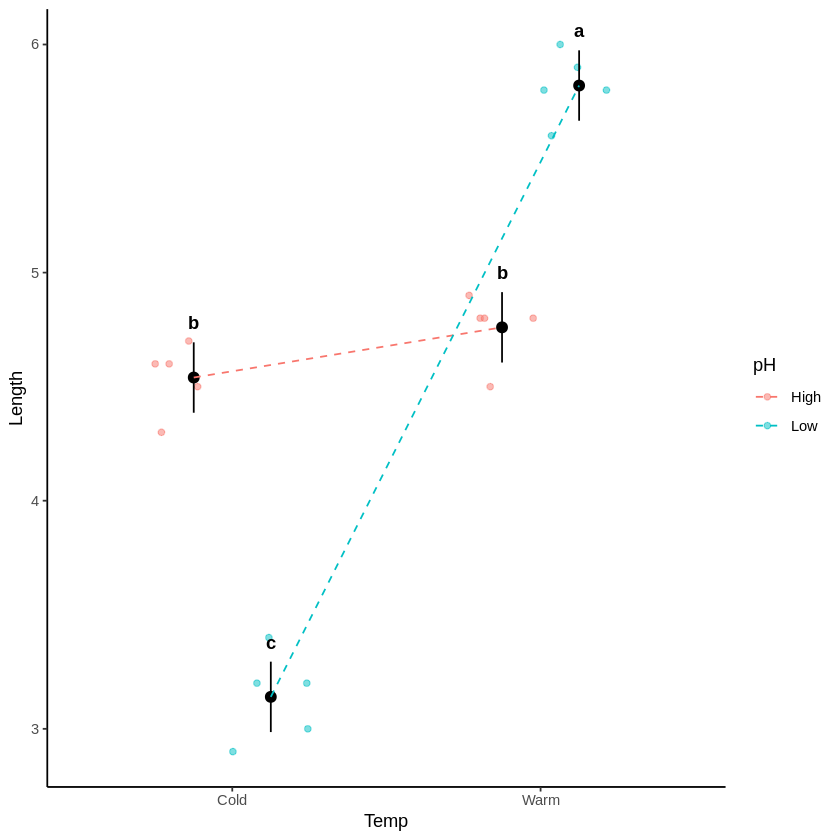

In [ ]:
# Edit all instances of your data frame(s), explanatory and response variables accordingly
ggplot(sticklebacks, aes(y = Length, x = Temp, color = pH)) +
  geom_jitter(alpha = 0.5, position = position_jitterdodge(jitter.width = 0.5, dodge.width = 0.5)) +
  theme_classic() +
  geom_pointrange(data = cld_sticklebacksANOVAinteraction,
                  aes(x = Temp, group = pH, y = emmean, ymin = lower.CL, ymax = upper.CL),
                  color = "black", position = position_dodge(width = 0.5)) +
  geom_text(data = cld_sticklebacksANOVAinteraction,
            aes(x = Temp, group = pH, y = upper.CL, label = Letters),
            position = position_dodge(width = 0.5), vjust = -1, color = "black", fontface = "bold") +
  geom_line(data = cld_sticklebacksANOVAinteraction,
            aes(x = Temp, group = pH, color = pH, y = emmean),
            position = position_dodge(width = 0.5), linetype = "dashed")

Recall from Colabs 9 and 10 that jitter plots are especially useful for situations in which we have fewer data points per group and/or fewer groups. For other situations, violin plots may be preferred.

Here's the code to create a filled violin plot. This is identical to the jitter plot above except we changed **`color=pH`** to **`fill=pH`** in the aesthetics call, changed **`geom_jitter`** to **`geom_violin`** and resorted to **`position = position_dodge`** for this layer, and changed the dodge **`width = `** argument to a different value. (For jitter plots it is fine if the points slightly overlap between the dodged color groups, but overlap affects filled violins much more so.)

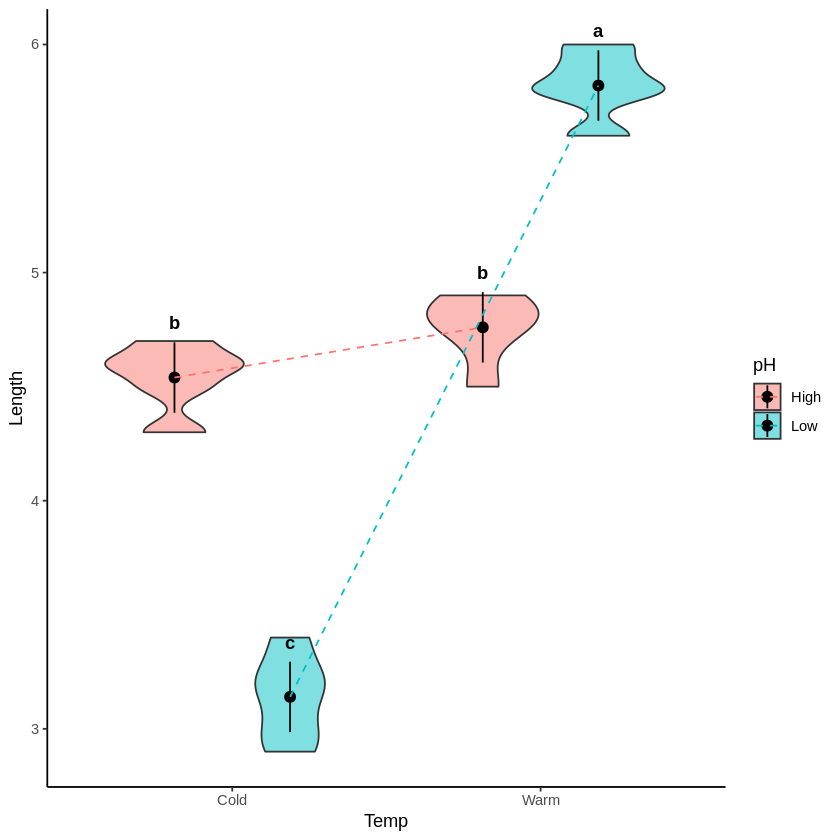

In [ ]:
# Edit all instances of your data frame(s), explanatory and response variables accordingly
ggplot(sticklebacks, aes(y = Length, x = Temp, fill = pH)) +
  geom_violin(alpha = 0.5, position = position_dodge(width = 0.75)) +
  theme_classic() +
  geom_pointrange(data = cld_sticklebacksANOVAinteraction,
                  aes(x = Temp, group = pH, y = emmean, ymin = lower.CL, ymax = upper.CL),
                  color = "black", position = position_dodge(width = 0.75)) +
  geom_text(data = cld_sticklebacksANOVAinteraction,
            aes(x = Temp, group = pH, y = upper.CL, label = Letters),
            position = position_dodge(width = 0.75), vjust = -1, color = "black", fontface = "bold") +
  geom_line(data = cld_sticklebacksANOVAinteraction,
            aes(x = Temp, group = pH, color = pH, y = emmean),
            position = position_dodge(width = 0.75), linetype = "dashed")

### Model comparison

Models can be constructed with different terms. *Is it better for us to use a model that includes or doesn't include an interaction term between our main effects of Temp and pH on Length?*

We want to find a model that balances explanatory power (adequately describes the causal relationships) and predictive power (adequately estimates results). More complex models are not necessarily better because we might be overfitting the data -- sacrificing explanatory power for (illusory) predictive power. Instead, we want to balance these tradeoffs.

Before we can explore these tradeoffs, we need to first fit a reduced model, which lacks the interaction term. Whenever you fit a model, you must also evaluate the assumptions:

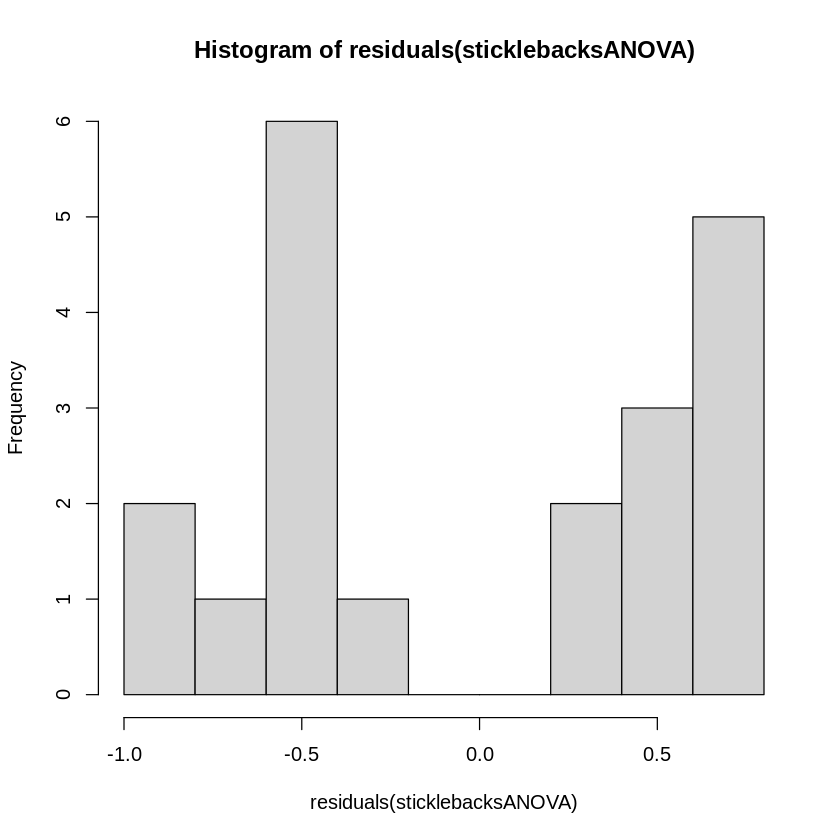

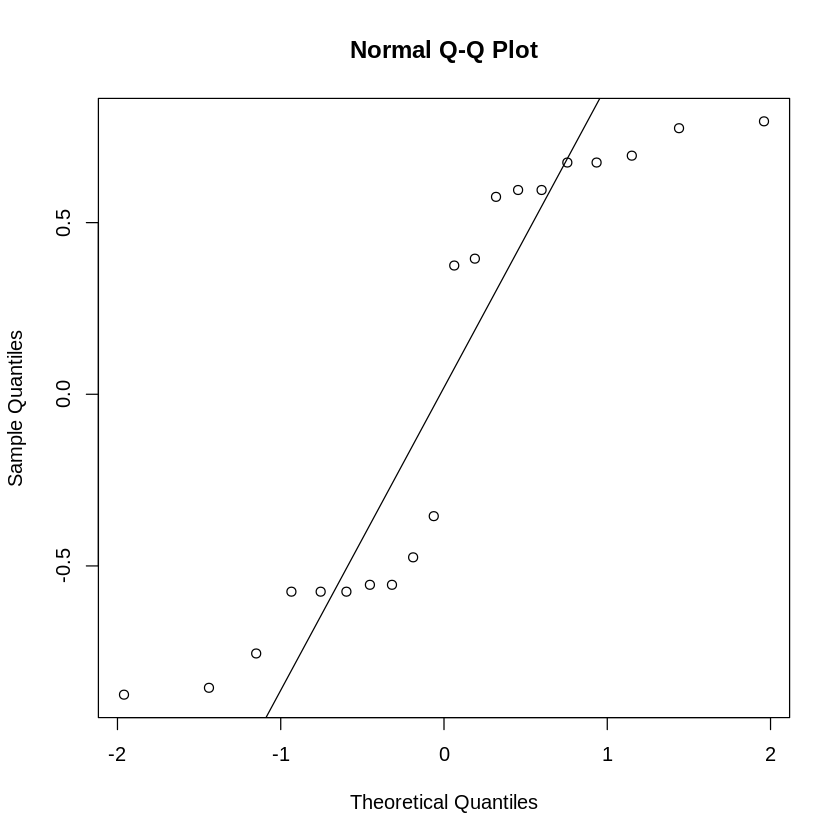

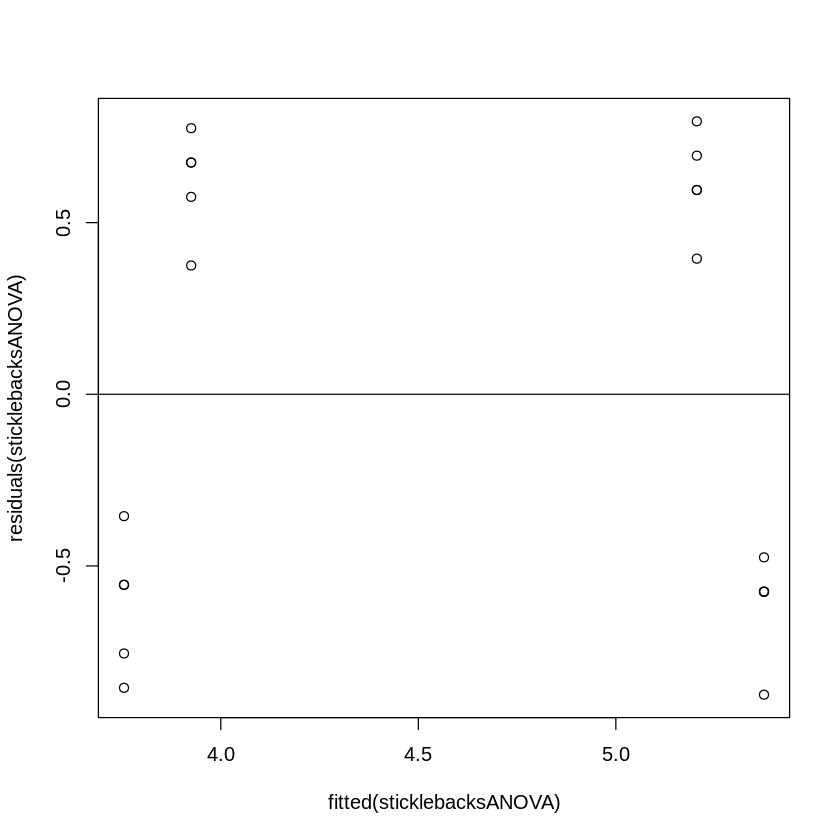

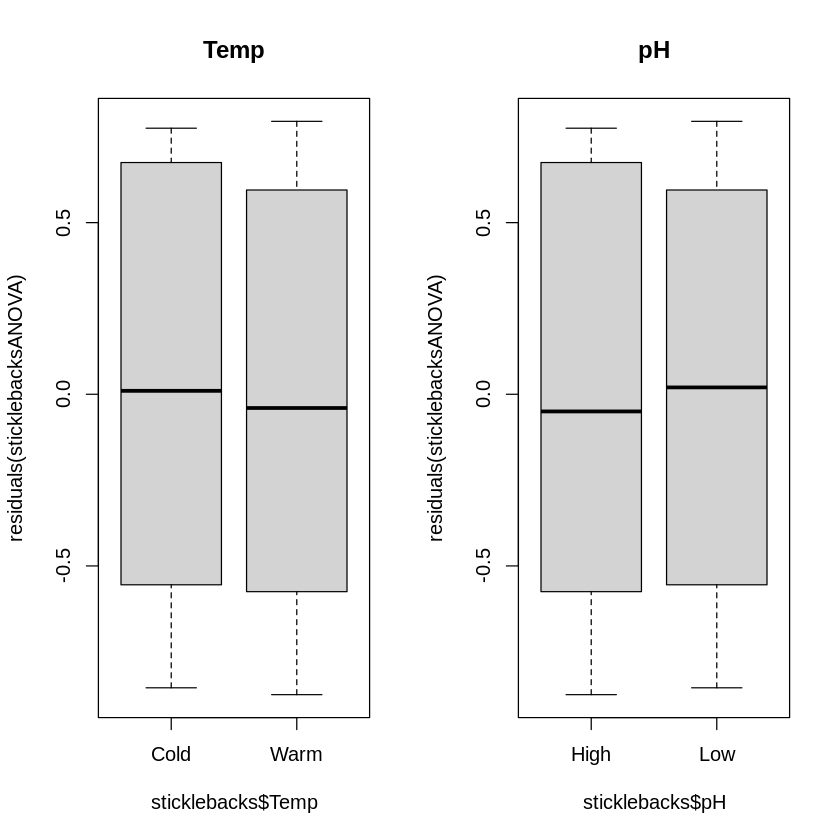

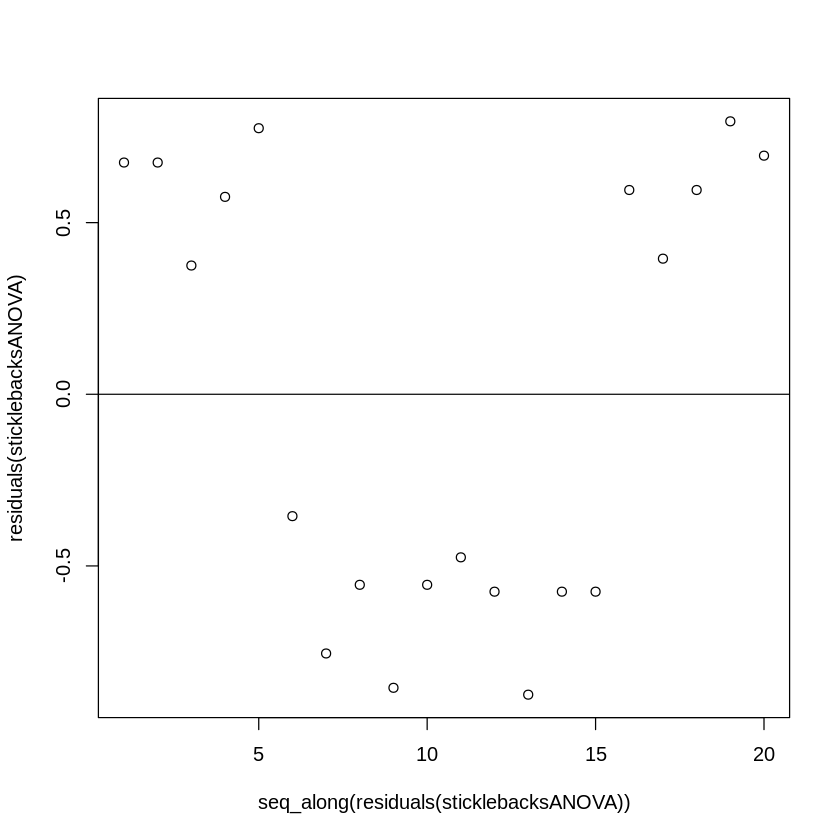

In [ ]:
sticklebacksANOVA <- lm(Length ~ Temp + pH, data = sticklebacks) # Note the + instead of * because we are not including the interaction

# Normality
hist(residuals(sticklebacksANOVA))
qqnorm(residuals(sticklebacksANOVA))
qqline(residuals(sticklebacksANOVA))

# Homoscedasticity
plot(residuals(sticklebacksANOVA) ~ fitted(sticklebacksANOVA), data = sticklebacks)
abline(h=0)
par(mfrow = c(1, 2)) # To plot the next three plots side by side
boxplot(residuals(sticklebacksANOVA) ~ sticklebacks$Temp, main = "Temp")
boxplot(residuals(sticklebacksANOVA) ~ sticklebacks$pH, main = "pH")
par(mfrow = c(1, 1)) # resets the plotting field to be a single plot

# Independence
plot(seq_along(residuals(sticklebacksANOVA)), residuals(sticklebacksANOVA))
abline(h = 0)

Normality for this reduced model looks not very good at all -- sort of bimodal. Homoscedasticy should be judged based on the boxplots, and it's fine (note we didn't perform the interaction boxplot because we don't have an interaction term in this model). Independence needs to be evaluated a different way because the data is already sorted by treatment. Overall, ANOVA is pretty robust to normality deviations, so let's ignore the deviation from normality.

Having met the assumptions well enough to check the output of the model, let's now do that:

,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),102.7042,1,218.5605349,3.897447e-11
Temp,10.5125,1,22.3712211,1.935699e-04
pH,0.1445,1,0.3075045,5.864377e-01
Residuals,7.9885,17,NA,NA


$r.squared
[1] 0.5715588

$adj.r.squared
[1] 0.8571863

 contrast              estimate    SE df t.ratio p.value
 Cold High - Warm High    -1.45 0.307 17  -4.730  0.0010
 Cold High - Cold Low      0.17 0.307 17   0.555  0.9440
 Cold High - Warm Low     -1.28 0.434 17  -2.952  0.0403
 Warm High - Cold Low      1.62 0.434 17   3.737  0.0081
 Warm High - Warm Low      0.17 0.307 17   0.555  0.9440
 Cold Low - Warm Low      -1.45 0.307 17  -4.730  0.0010

P value adjustment: tukey method for comparing a family of 4 estimates 

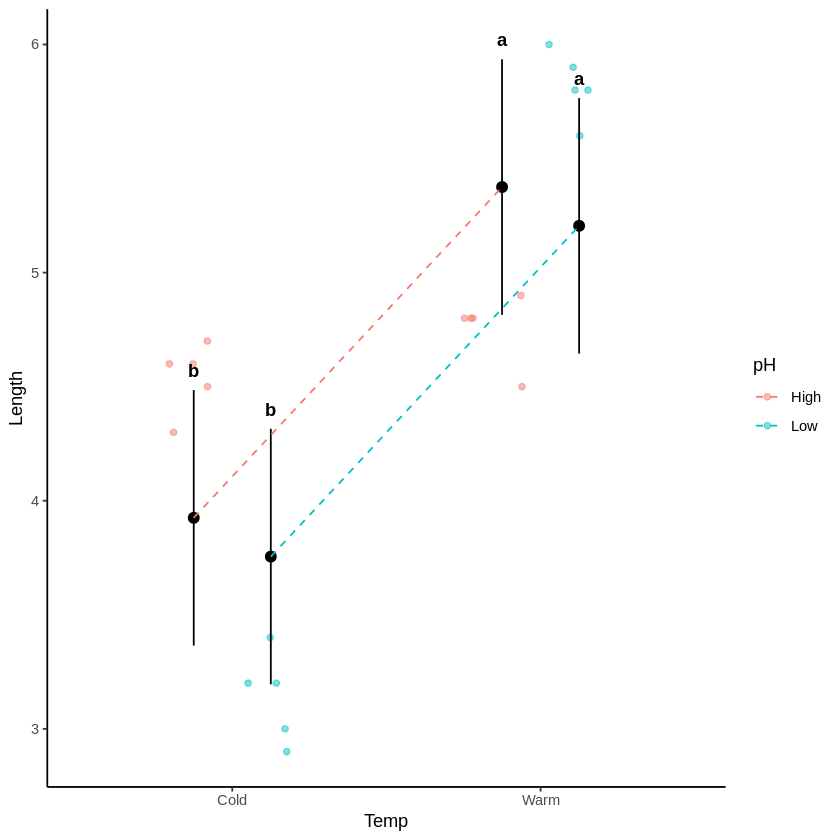

In [ ]:
# Type III sum of squares ANOVA table with df, F-values, p-values
Anova_sticklebacksANOVA <- Anova(sticklebacksANOVA, type = "III") # Note: 'A' in Anova is capitalized
Anova_sticklebacksANOVA

# R-squared and Adjusted R-squared
calculate_r_squared(Anova_sticklebacksANOVA)

# Emmeans, Tukey results, CLD generation
emmeans_sticklebacksANOVA <- emmeans(sticklebacksANOVA, ~ Temp * pH)
pairs(emmeans_sticklebacksANOVA, adjust = "tukey")
cld_sticklebacksANOVA <- generate_cld(emmeans_sticklebacksANOVA)

# Jitter plot
ggplot(sticklebacks, aes(x = Temp, color = pH, y = Length)) +
  geom_jitter(alpha = 0.5, position = position_jitterdodge(jitter.width = 0.5, dodge.width = 0.5)) +
  theme_classic() +
  geom_pointrange(data = cld_sticklebacksANOVA,
                  aes(x = Temp, group = pH, y = emmean, ymin = lower.CL, ymax = upper.CL),
                  color = "black", position = position_dodge(width = 0.5)) +
  geom_text(data = cld_sticklebacksANOVA,
            aes(x = Temp, group = pH, y = upper.CL, label = Letters),
            position = position_dodge(width = 0.5), vjust = -1, color = "black", fontface = "bold") +
  geom_line(data = cld_sticklebacksANOVA,
            aes(x = Temp, group = pH, color = pH, y = emmean),
            position = position_dodge(width = 0.5), linetype = "dashed")

Our conclusions are very different than with the full model! We can see that excluding an interaction term makes temperature significant but not pH.

So, returning to our guiding question for this section -- Which is a better model?

There are many approaches for comparing models to determine the "best" one. You want your goals, including the modeled biological phenomenon, to drive your decisions. Here's four options:

**F-Test**
* Best for: Comparing nested models in ANOVA/linear models.
* Key assumptions: Normality, homoscedasticity, nested models.

**Adjusted R²**
* Best for: Comparing explanatory power between models.
* Key assumptions: Same as linear model assumptions.

**AIC/AICc**
* Best for: Model selection (prediction-focused).
* Key assumptions: Requires ML/REML fitting, no strict distributional assumptions.

**BIC**
* Best for: Model selection (inference-focused).
* Key assumptions: Requires ML/REML fitting, simpler models favored.

#### F-Test

Use an F-test to compare the residual variance between two nested models; the simpler model lacking the interaction term is nested within the more complex model. This is a hypothesis test evaluating whether the extra term(s) in the more complex model significantly contribute to explaining the variance in the response variable. The null hypothesis is that the simpler model is sufficient. If the null is rejected, then the full model is better.

In [ ]:
anova(sticklebacksANOVA, sticklebacksANOVAinteraction)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,17,7.9885,NA,NA,NA,NA
2,16,0.4240,1,7.5645,285.4528,1.267076e-11


#### Adjusted R²

Adjusted R-squared penalizes the addition of predictors so it is useful for comparing models of different complexities. The model with the higher adjusted
R-squared is preferred. If adjusted R-squared drops after including the interaction term, it may indicate that the added complexity is not justified.

In [ ]:
calculate_r_squared(Anova_sticklebacksANOVA)$adj.r.squared
calculate_r_squared(Anova_sticklebacksANOVAinteraction)$adj.r.squared

[1] 0.521154

[1] 0.9612975

#### AIC/AICc and BIC

Compare Akaike Information Criterion (AIC) or Bayesian Information Criterion (BIC) for both models. For medium or small sample sizes (), try AICc instead of AIC. All of these metrics reflect model fit and penalize for the number of parameters. A lower value is preferrable. Use AIC for prediction-focused models and BIC for inference-focused models.

In [ ]:
AIC(sticklebacksANOVA, sticklebacksANOVAinteraction)
BIC(sticklebacksANOVA, sticklebacksANOVAinteraction)

# Custom function to calculate AICc
calculate_AICc <- function(model) {
  # Extract AIC and number of parameters
  aic <- AIC(model)
  n <- length(residuals(model))  # Number of observations
  k <- length(coef(model))  # Number of parameters (including intercept)

  # Calculate AICc
  aicc <- aic + (2 * k * (k + 1)) / (n - k - 1)
  return(aicc)
}

# Compare AICc for the two models
calculate_AICc(sticklebacksANOVA)
calculate_AICc(sticklebacksANOVAinteraction)

,df,AIC
,<dbl>,<dbl>
sticklebacksANOVA,4,46.40296
sticklebacksANOVAinteraction,5,-10.31754


,df,BIC
,<dbl>,<dbl>
sticklebacksANOVA,4,50.385885
sticklebacksANOVAinteraction,5,-5.338879


[1] 47.90296

[1] -7.650874

For this sticklebacks dataset, all of these methods agree that **the model including the interaction is much better than the model excluding it.** That should feel right -- just compare the jitter plot showing the raw data and means estimated from one or the other model and it should be clear that the more complex model is better.

But these results won't always be so clear. Sometimes the difference between models will be slight. Sometimes different model comparison methods will disagree on which model is best. In those cases, remember that different methods prioritize different aspects of model evaluation: variance explained (F-test, Adjusted R-squared), predictive accuracy (AIC/AICc), or simplicity (BIC). No single method is always correct. Choose the method(s) that align with your goals (e.g., prediction, explanation, and/or simplicity) and the assumptions of your data. If methods disagree, examine their assumptions and decide based on the biological or experimental context and your goals.

**What about p-values?**

If a model component is significant, should it always be kept in the model? *Not necessarily!* Keep it if the component aligns with your biological or experimental question and its inclusion improves the model's interpretability or explanatory power.

If a model component is nonsignificant, should it always be dropped? *Not always!* Drop it if the goal is parsimony (simpler models are preferred), and dropping the term does not substantially reduce the model's explanatory or predictive power.

Should model comparison happen no matter what the p-values are across the model components for the first model investigated? *Yes, model comparison is always valuable!* A significant p-value does not necessarily mean the model is optimal, and a nonsignificant p-value does not mean a model component is useless. Model comparison provides additional tools to evaluate fit, complexity, and predictive performance. Comparing models helps clarify the trade-offs between explanatory power, simplicity, and generalizability.

## Questions
For each lab, add new code **and** text boxes (or **`#`**-marked comments within code boxes) to the bottom and/or within the tutorial to practice the activities.

1.   Fit a two-way ANOVA using the dataset filtered from MammalSizes by first running the codeblock below.

*   Then make a new variable in the **`filtered_mammal`** dataset: log-transformed **`EQ`**, called **`log_EQ`**.
*   Set **`log_EQ`** as your response variable and **`Order`** and **`Openness`** as your predictors, including the interaction term. This model is investigating whether order (primates versus rodents) and openness (where 1 is **`habitat_openness`** > 0.1) are predictive of EQ, which is encephalization quotient, a measure of brain size relative to body size.
*   Complete your assumption testing.
*   Evaluate the significance of the model components and the magnitude of the adjusted R-squared value.
*   Fit a reduced model without the interaction term.
*   Complete your assumption testing.
*   Is the model a better fit when the interaction term is excluded; evaluate the adjusted R-squared value to determine this.
*   And does both order and openness significantly predict log EQ? Use the model componets and **the plot** to help answer this.
*   What else can you conclude about the results? Try using ChatGPT to interpret them for you.

In [ ]:
# Load the dplyr package
library(dplyr)

# Read the data
mammal <- read.csv("MammalSizes.csv", stringsAsFactors = TRUE)

# Filtering out humans and adding the Openness categorical variable
mammal <- mammal %>% filter(Binomial != "Homo_sapiens") %>% mutate(Openness = ifelse(Habitat_Openness > 0.1, 1, 0))
mammal$Openness <- factor(mammal$Openness)

# Filtering out Orders with few species across both levels of Openness
# Step 1: Create a summary table with counts
count_table <- mammal %>%
  group_by(Order, Openness) %>%
  summarise(Count = n()) %>%
  ungroup()

# Step 2: Filter Orders where both levels of Openness have more than 2 entries
valid_orders <- count_table %>%
  group_by(Order) %>%
  # Ensure that each level of Openness within an Order has more than 2 entries
  filter(sum(Count[Openness == 0]) > 20 & sum(Count[Openness == 1]) > 20) %>%
  ungroup() %>%
  select(Order) %>%
  distinct()

# Step 3: Filter the original dataset to keep only valid Orders
filtered_mammal <- mammal %>%
  filter(Order %in% valid_orders$Order) %>% droplevels()

# The final dataset for you to use is filtered_mammal

`summarise()` has grouped output by 'Order'. You can override using the
`.groups` argument.
